Data Processing

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Mount drive to import data file
from google.colab import drive
# drive.mount('/content/drive')

# Ethan drive mount
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Importing data
# retrieved from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download
import torchvision.transforms as transforms
import torchvision.datasets as d
from torch.utils.data import DataLoader, Dataset, Subset

# https://pytorch.org/vision/0.9/transforms.html
# https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html
# https://discuss.pytorch.org/t/resizing-dataset/75620/4

# transform images to rescale, resize, normalize
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shortest side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load your dataset with the defined transformations
# my path is /content/drive/My Drive/Colab Notebooks/APS360/Data NvsP
# dear teammates will have to make their own path with the data that's been shared
# graces path '/content/drive/My Drive/360 Data'
# ETHAN JAN WANG JAN BOYAN ETHAN OH BOY OH BOY path "/content/gdrive/MyDrive/Uni/Year 2/Sem 2/APS360/Data NvsP"
# Renzo path  "/content/gdrive/MyDrive/Colab Notebooks/APS360/Data NvsP"
dataset = d.ImageFolder("/content/gdrive/MyDrive/Uni/Year 2/Sem 2/APS360/Data NvsP", transform=transform)

In [ ]:
# pick 80/10/10 split, remove 90% of the dataset to reduce size of dataset due to computational cost temporarily
torch.manual_seed(1000)
print(f'Total images: {len(dataset)}')
extra, train, val, test = torch.utils.data.random_split(dataset, [0.90, 0.08, 0.01, 0.01])
print(f'Training images: {len(train)}')
print(f'Validation images: {len(val)}')
print(f'Test images: {len(test)}')

Total images: 3012
Training images: 241
Validation images: 30
Test images: 30


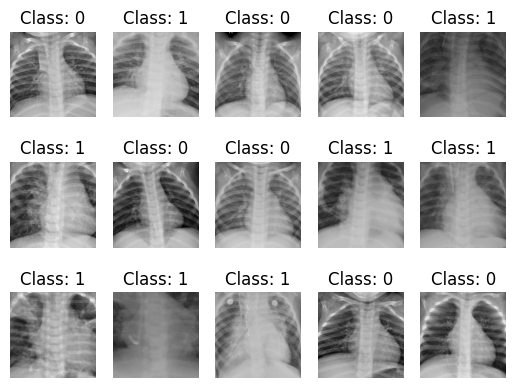

In [ ]:
# Function to denormalize and convert tensor to numpy array
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to the valid range [0, 1]
    plt.imshow(img)
    # plt.show()

# Visualize the first 15 images
k = 0
for img, label in train:
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    imshow(img)
    plt.title(f'Class: {label}')  # Set the label as xlabel

    k += 1
    if k > 14:
        break
plt.show()

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if isinstance(image, torch.Tensor):
          image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def dataset_to_numpy(dataset):
    X, y = [], []

    for img, label in dataset:
        img = img.numpy().flatten()  # Convert to NumPy and flatten
        X.append(img)
        y.append(label)

    return np.array(X, dtype=np.float32), np.array(y)

# Convert training and test sets
x_train, y_train = dataset_to_numpy(train)
x_test, y_test = dataset_to_numpy(test)

Baseline Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [ ]:
# https://scikit-learn.org/stable/modules/svm.html
# Alter hyperparameter C to achieve best results
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

prediction = svm_model.predict(x_test)

# Output results
accuracy = svm_model.score(x_test, y_test)
print(f"Model accuracy {accuracy*100}\nModel error {(1-accuracy)*100}")

print(classification_report(y_test, prediction))

Model accuracy 93.33333333333333
Model error 6.666666666666665
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        16

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



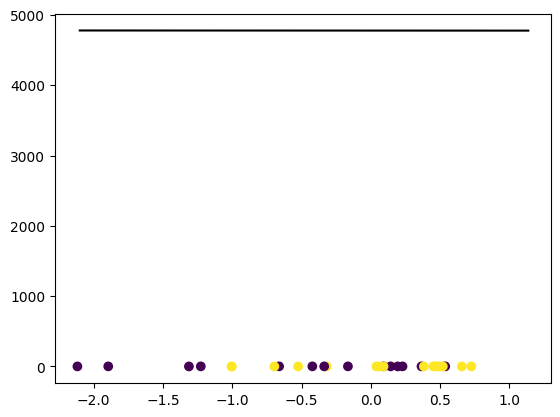

In [ ]:
# Plotting results
# Visualize hyperplane

w = svm_model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(x_test[:,0].min(), x_test[:,1].max())
yy = a * xx - (svm_model.intercept_[0]) / w[1]

# Plot the hyperplane
plt.plot(xx, yy, 'k-')
plt.scatter(x_test[:, 29], x_test[:, 562], c=y_test)
plt.show()


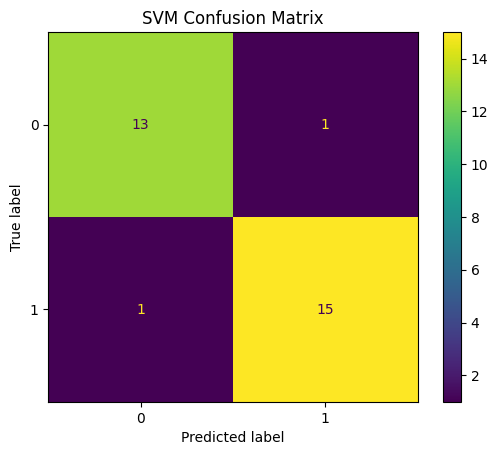

In [ ]:
cm=confusion_matrix(y_test,prediction)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('SVM Confusion Matrix')
plt.show()

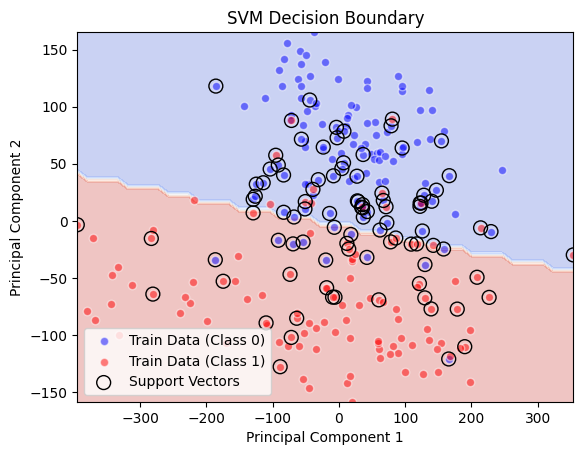

In [ ]:
# Step 1: Apply PCA to Reduce for Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train)
support_vectors_pca = pca.transform(svm_model.support_vectors_)  # Only transform support vectors

# Step 2: Create a Smaller Grid for Decision Boundary
x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),  # Reduce grid size from 100x100 to 50x50
                     np.linspace(y_min, y_max, 50))

# Step 3: Predict Directly on PCA-Reduced Grid (No Inverse Transform)
grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
Z = svm_model.predict(pca.inverse_transform(grid_points_pca))  # Predict without large inverse transformation
Z = Z.reshape(xx.shape)

# Step 4: Plot Decision Boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

classes = np.unique(y_train)
colors = ["blue", "red"]  # or however many classes you have

for cls, col in zip(classes, colors):
    plt.scatter(X_train_pca[y_train == cls, 0],
                X_train_pca[y_train == cls, 1],
                c=col,
                alpha=0.5,
                edgecolors='w',
                label=f"Train Data (Class {cls})")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], edgecolors='black', facecolors='none', s=100, label="Support Vectors")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary")
plt.legend()
plt.show()


Primary Model

In [ ]:
# model name function from lab 2 to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# evaluate function from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# from tut 3
def get_accuracy(model, train=False):
    if train:
        data = train
    else:
        data = val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# train net function from lab 2
def train_net(net, batchsize, lr, epoch, train, val):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #Comvert data to tensors and load the batches
    traindataset=Dataset(train, transform=transform)
    valdataset=Dataset(val, transform=transform)
    trainloader=torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True)
    valloader=torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True)

    #set up error and loss array
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    #iterate through and train the data
    for epoch in range(epoch):
        total_train_samples=0
        i=0
        for image, label in trainloader:
            optimizer.zero_grad()
            output=net(image)
            loss=criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch]+=loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch] += (predicted != label).sum().item()
            total_train_samples+=len(label)
            i+=1
        #calculate error loss for each epoch
        train_loss[epoch]/=(i+1)
        train_error[epoch]/=total_train_samples
        #evaluate v=on validation for each epoch
        val_err[epoch], val_loss[epoch] = evaluate(net, valloader, criterion)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[epoch]}, Train Error: {train_error[epoch]}, Val Loss: {val_loss[epoch]}, Val Error: {val_err[epoch]}")
        #checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch)
        torch.save(net.state_dict(), model_path)
    #save the model to plot later
    epochs = np.arange(1, epoch + 1)
    a=np.savetxt("{}_train_err.csv".format(model_path), train_error)
    b=np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    c=np.savetxt("{}_val_err.csv".format(model_path), val_err)
    d=np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
#Convolutional Neural Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Check if the model can overfit
small_train = Subset(train, range(10))
small_val = Subset(val, range(10))

net=Net()
train_net(net, 12, 0.01, 20, small_train, small_val)

Epoch 1: Train Loss: 0.3445354104042053, Train Error: 0.2, Val Loss: 0.6774588823318481, Val Error: 0.4
Epoch 2: Train Loss: 0.31331363320350647, Train Error: 0.1, Val Loss: 0.6636346578598022, Val Error: 0.4
Epoch 3: Train Loss: 0.2737836241722107, Train Error: 0.0, Val Loss: 0.6583260297775269, Val Error: 0.3
Epoch 4: Train Loss: 0.21821165084838867, Train Error: 0.0, Val Loss: 0.6524325609207153, Val Error: 0.4
Epoch 5: Train Loss: 0.15584467351436615, Train Error: 0.0, Val Loss: 0.6365581154823303, Val Error: 0.5
Epoch 6: Train Loss: 0.09655485302209854, Train Error: 0.0, Val Loss: 0.6130272150039673, Val Error: 0.4
Epoch 7: Train Loss: 0.04964211583137512, Train Error: 0.0, Val Loss: 0.5994174480438232, Val Error: 0.4
Epoch 8: Train Loss: 0.02154567278921604, Train Error: 0.0, Val Loss: 0.599917471408844, Val Error: 0.4
Epoch 9: Train Loss: 0.008105062879621983, Train Error: 0.0, Val Loss: 0.6119469404220581, Val Error: 0.5
Epoch 10: Train Loss: 0.0027909898199141026, Train Error:

Hyperparameter Tuning

In [ ]:
#From lab 2 to help plot curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Tune hyperparameters
# Model 1
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.name = "Net1"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1=Net1()

train_net(net1, 64, 0.01, 30, train, val)

Epoch 1: Train Loss: 0.5379950642585755, Train Error: 0.44398340248962653, Val Loss: 0.6330038905143738, Val Error: 0.4
Epoch 2: Train Loss: 0.4913833498954773, Train Error: 0.2863070539419087, Val Loss: 0.6083232164382935, Val Error: 0.23333333333333334
Epoch 3: Train Loss: 0.4129572451114655, Train Error: 0.22821576763485477, Val Loss: 0.4379040002822876, Val Error: 0.23333333333333334
Epoch 4: Train Loss: 0.4638055801391602, Train Error: 0.33195020746887965, Val Loss: 0.4304982125759125, Val Error: 0.23333333333333334
Epoch 5: Train Loss: 0.34263756275177004, Train Error: 0.21991701244813278, Val Loss: 0.4294574558734894, Val Error: 0.26666666666666666
Epoch 6: Train Loss: 0.2561331570148468, Train Error: 0.07883817427385892, Val Loss: 0.29734399914741516, Val Error: 0.1
Epoch 7: Train Loss: 0.12253363132476806, Train Error: 0.029045643153526972, Val Loss: 0.451305091381073, Val Error: 0.13333333333333333
Epoch 8: Train Loss: 0.08864670842885972, Train Error: 0.04564315352697095, Va

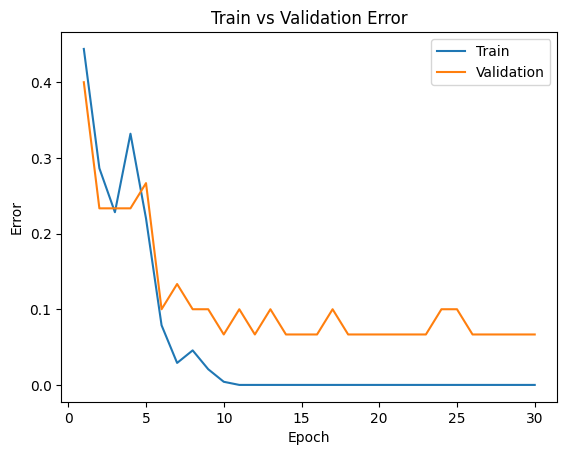

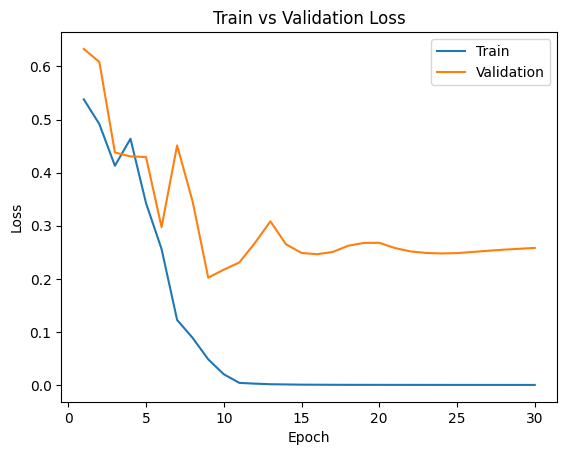

In [ ]:
model_path = get_model_name("Net1", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Model 2
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.name = "Net2"
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2 = Net2()

train_net(net2, 32, 0.001, 30, train, val) #Decreased batch size and decreased learning rate

Epoch 1: Train Loss: 0.5897915874208722, Train Error: 0.519774011299435, Val Loss: 0.6413378119468689, Val Error: 0.3181818181818182
Epoch 2: Train Loss: 0.5631100024495806, Train Error: 0.384180790960452, Val Loss: 0.6263713240623474, Val Error: 0.3181818181818182
Epoch 3: Train Loss: 0.5417015041623797, Train Error: 0.384180790960452, Val Loss: 0.6272220015525818, Val Error: 0.3181818181818182
Epoch 4: Train Loss: 0.5170501896313259, Train Error: 0.3107344632768362, Val Loss: 0.608872652053833, Val Error: 0.3181818181818182
Epoch 5: Train Loss: 0.4785082595688956, Train Error: 0.13559322033898305, Val Loss: 0.5784334540367126, Val Error: 0.3181818181818182
Epoch 6: Train Loss: 0.4440588227340153, Train Error: 0.1864406779661017, Val Loss: 0.549532413482666, Val Error: 0.2727272727272727
Epoch 7: Train Loss: 0.39959979483059477, Train Error: 0.062146892655367235, Val Loss: 0.5192417502403259, Val Error: 0.2727272727272727
Epoch 8: Train Loss: 0.392130902835301, Train Error: 0.20338983

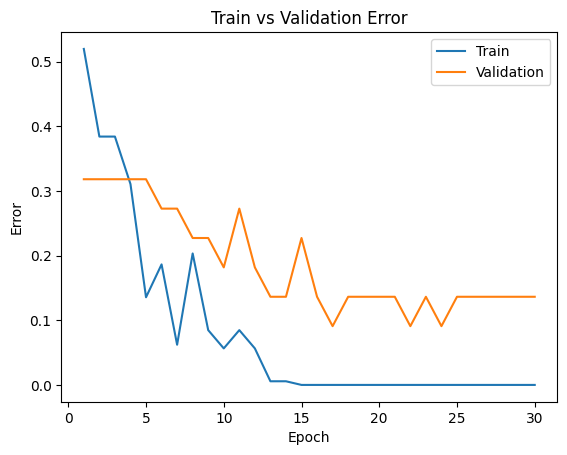

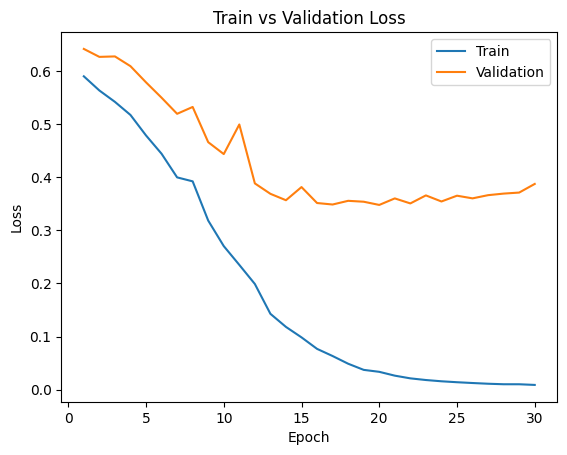

In [ ]:
model_path = get_model_name("Net2", batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Model 3
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.name = "Net3"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net3=Net3()

train_net(net3, 64, 0.01, 30, train, val)

Epoch 1: Train Loss: 0.5498708486557007, Train Error: 0.46887966804979253, Val Loss: 0.6552741527557373, Val Error: 0.4
Epoch 2: Train Loss: 0.5511484026908875, Train Error: 0.46887966804979253, Val Loss: 0.6521895527839661, Val Error: 0.4
Epoch 3: Train Loss: 0.5379527926445007, Train Error: 0.42738589211618255, Val Loss: 0.6506438851356506, Val Error: 0.2
Epoch 4: Train Loss: 0.5496768236160279, Train Error: 0.3983402489626556, Val Loss: 0.6109311580657959, Val Error: 0.36666666666666664
Epoch 5: Train Loss: 0.5053091526031495, Train Error: 0.24066390041493776, Val Loss: 0.6401070952415466, Val Error: 0.23333333333333334
Epoch 6: Train Loss: 0.49564534425735474, Train Error: 0.1908713692946058, Val Loss: 0.5316531658172607, Val Error: 0.26666666666666666
Epoch 7: Train Loss: 0.4382708668708801, Train Error: 0.29045643153526973, Val Loss: 0.5018130540847778, Val Error: 0.13333333333333333
Epoch 8: Train Loss: 0.41303494572639465, Train Error: 0.2157676348547718, Val Loss: 0.9040757417

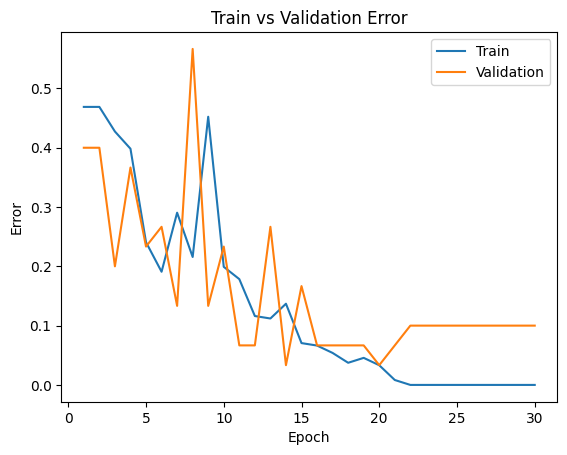

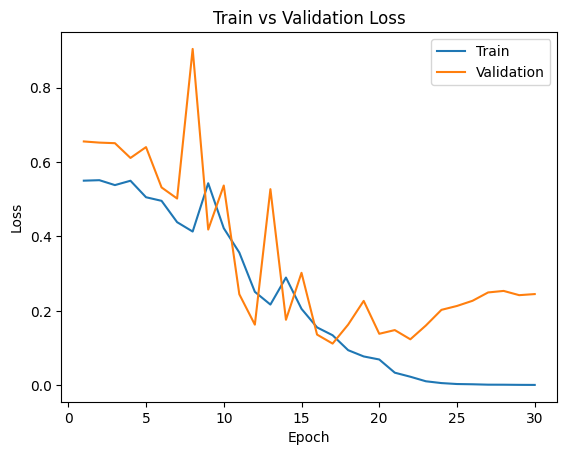

In [ ]:
model_path = get_model_name("Net3", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Model 4
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.name = "Net4"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net4=Net4()

train_net(net4, 56, 0.01, 30, train, val)

Epoch 1: Train Loss: 0.5800713996092478, Train Error: 0.46887966804979253, Val Loss: 0.6644374132156372, Val Error: 0.4
Epoch 2: Train Loss: 0.5658514102300009, Train Error: 0.45643153526970953, Val Loss: 0.6576961874961853, Val Error: 0.4
Epoch 3: Train Loss: 0.5693550010522207, Train Error: 0.46887966804979253, Val Loss: 0.6393722891807556, Val Error: 0.4
Epoch 4: Train Loss: 0.5397937397162119, Train Error: 0.2863070539419087, Val Loss: 0.6517215371131897, Val Error: 0.16666666666666666
Epoch 5: Train Loss: 0.5321686764558157, Train Error: 0.2033195020746888, Val Loss: 0.563366711139679, Val Error: 0.23333333333333334
Epoch 6: Train Loss: 0.5098987718423208, Train Error: 0.24896265560165975, Val Loss: 0.6236039400100708, Val Error: 0.4666666666666667
Epoch 7: Train Loss: 0.4292759448289871, Train Error: 0.3236514522821577, Val Loss: 0.40278881788253784, Val Error: 0.2
Epoch 8: Train Loss: 0.34385502338409424, Train Error: 0.15767634854771784, Val Loss: 0.3736700117588043, Val Error:

In [ ]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.name = "Net5"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 356)
        self.fc3 = nn.Linear(356, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net5=Net5()

train_net(net5, 56, 0.01, 30, train, val)

Epoch 1: Train Loss: 0.5783799787362417, Train Error: 0.5020746887966805, Val Loss: 0.6821221113204956, Val Error: 0.4
Epoch 2: Train Loss: 0.567529688278834, Train Error: 0.46887966804979253, Val Loss: 0.6663188934326172, Val Error: 0.4
Epoch 3: Train Loss: 0.5634432435035706, Train Error: 0.46887966804979253, Val Loss: 0.6566464900970459, Val Error: 0.4
Epoch 4: Train Loss: 0.5633977750937144, Train Error: 0.46887966804979253, Val Loss: 0.6519037485122681, Val Error: 0.4
Epoch 5: Train Loss: 0.5574017365773519, Train Error: 0.46887966804979253, Val Loss: 0.6565012335777283, Val Error: 0.4
Epoch 6: Train Loss: 0.5449065268039703, Train Error: 0.4605809128630705, Val Loss: 0.6288124322891235, Val Error: 0.4
Epoch 7: Train Loss: 0.5414930582046509, Train Error: 0.46887966804979253, Val Loss: 0.6265389323234558, Val Error: 0.2
Epoch 8: Train Loss: 0.5180512964725494, Train Error: 0.12448132780082988, Val Loss: 0.5745838284492493, Val Error: 0.4
Epoch 9: Train Loss: 0.510900229215622, Tra

Epoch 1: Train Loss: 0.554317307472229, Train Error: 0.46887966804979253, Val Loss: 0.6877080798149109, Val Error: 0.4
Epoch 2: Train Loss: 0.5516124248504639, Train Error: 0.46887966804979253, Val Loss: 0.6808174252510071, Val Error: 0.4
Epoch 3: Train Loss: 0.5503939032554627, Train Error: 0.46887966804979253, Val Loss: 0.6741999387741089, Val Error: 0.4
Epoch 4: Train Loss: 0.5483559012413025, Train Error: 0.46887966804979253, Val Loss: 0.6687700748443604, Val Error: 0.4
Epoch 5: Train Loss: 0.5443087577819824, Train Error: 0.46887966804979253, Val Loss: 0.6651729941368103, Val Error: 0.4
Epoch 6: Train Loss: 0.543001675605774, Train Error: 0.46887966804979253, Val Loss: 0.6568209528923035, Val Error: 0.4
Epoch 7: Train Loss: 0.5359711050987244, Train Error: 0.46887966804979253, Val Loss: 0.65342116355896, Val Error: 0.4
Epoch 8: Train Loss: 0.524214768409729, Train Error: 0.45643153526970953, Val Loss: 0.6311282515525818, Val Error: 0.4
Epoch 9: Train Loss: 0.5083084106445312, Trai

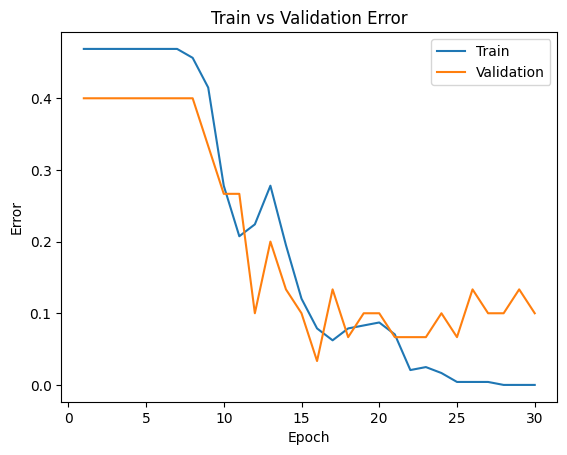

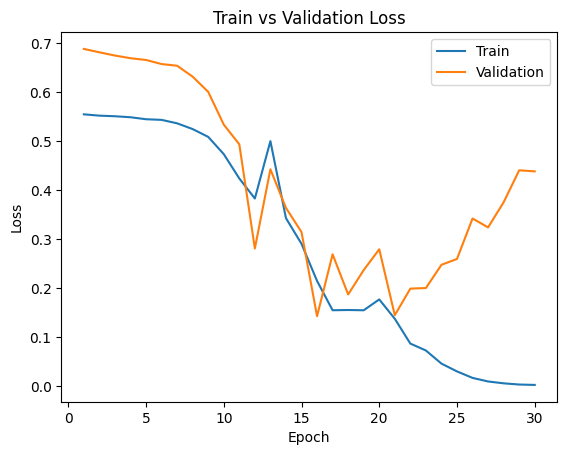

In [ ]:
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        self.name = "Net6"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 356)
        self.fc3 = nn.Linear(356, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net6=Net6()

train_net(net6, 64, 0.01, 30, train, val)

model_path = get_model_name("Net6", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)